In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Ridge

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучим `Ridge` регрессию из `sklearn`.



In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [8]:
set_random_seed(4567)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(random_state = 125)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
rmse = mean_squared_error(y_test, prediction)**(0.5)
print(rmse)

9.510160711373397


In [10]:
y_mean = np.array(pd.Series(y.mean(), index=np.arange(len(y_test))))
rmse_best = mean_squared_error(y_test, y_mean)**(0.5)
print(rmse_best)

10.8523584464736


## Linear Regression network
1. Создадим модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения линейной регрессии. В нем сами реализуем подсчет функции потерь, сделайте шаг градиентного спуска. 
3. Запусстим обучение на 10 эпохах, и посмотрим значение целевой метрики на тестовой выборке.
4. Выведем на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

In [11]:
class SGD:
    def __init__(self, parameters, learning_rate=0.001):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        for param in self.parameters:
            param.data -= self.learning_rate * param.grad.data

    def zero_grad(self):
        for p in self.parameters:
            p.grad = None


In [12]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
class Net(torch.nn.Module):
    def __init__(self, input_neirons):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_neirons, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

model = Net(90)
optimizer = SGD(model.parameters(), learning_rate=0.005)

In [13]:
def rmse(act, pred):
    diff = pred - act
    differences_squared = diff ** 2
    mean_diff = differences_squared.mean()
    return mean_diff**(0.5)

In [14]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

X_train_tensor = X_train_tensor.to(torch.float32)
X_test_tensor = X_test_tensor.to(torch.float32)
y_train_tensor = y_train_tensor.to(torch.float32)
y_test_tensor = y_test_tensor.to(torch.float32)

In [15]:
train_set = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=False
)
#размер батча в 128 оказался наиболее оптимальным при обучении

Эпоха 1 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 1 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 1, train loss: 1960.1335034792903, test loss: 1959.3589024307705


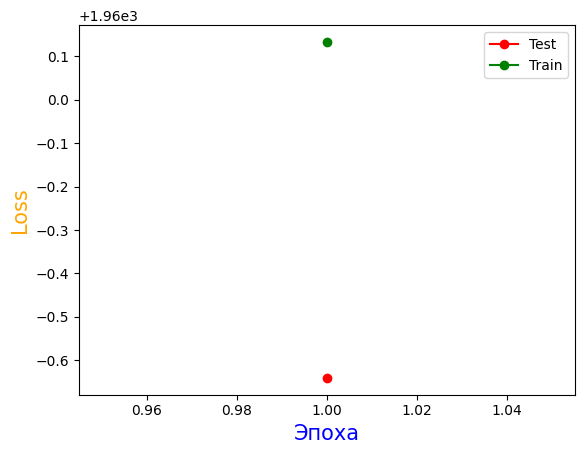

Эпоха 2 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 2 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 2, train loss: 1960.132363774518, test loss: 1959.3589024307705


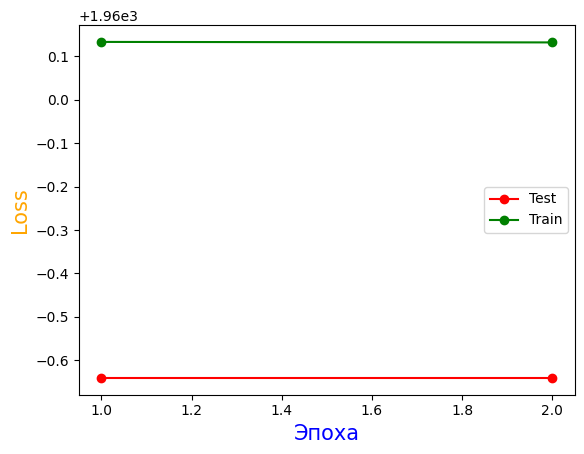

Эпоха 3 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 3 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 3, train loss: 1960.1328661058149, test loss: 1959.3589024307705


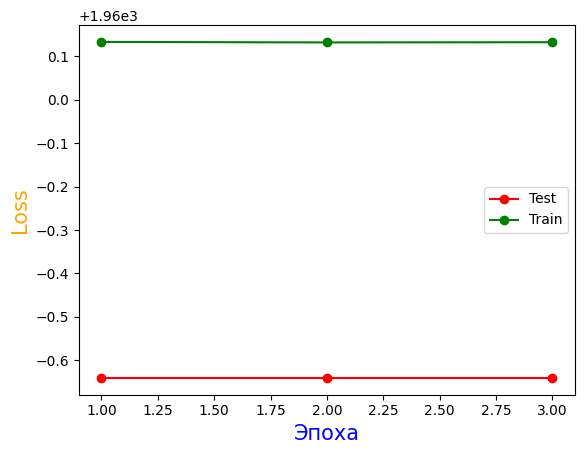

Эпоха 4 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 4 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 4, train loss: 1960.1358285430647, test loss: 1959.3589024307705


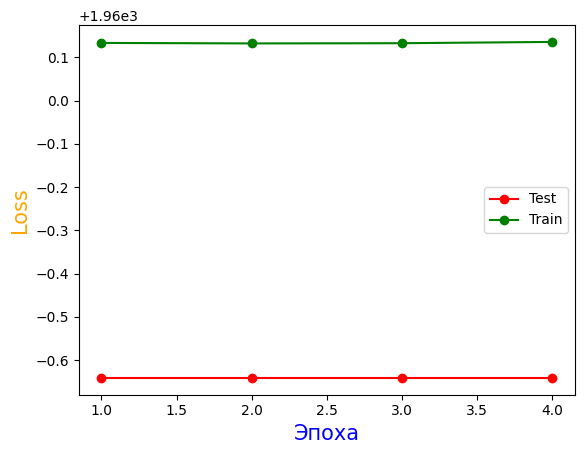

Эпоха 5 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 5 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 5, train loss: 1960.1339230264973, test loss: 1959.3589024307705


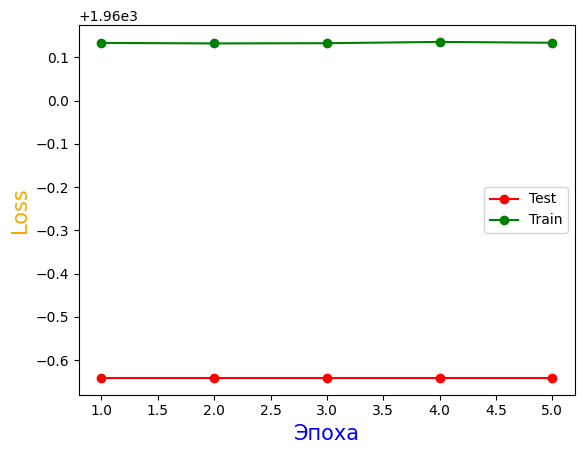

Эпоха 6 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 6 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 6, train loss: 1960.133080259529, test loss: 1959.3589024307705


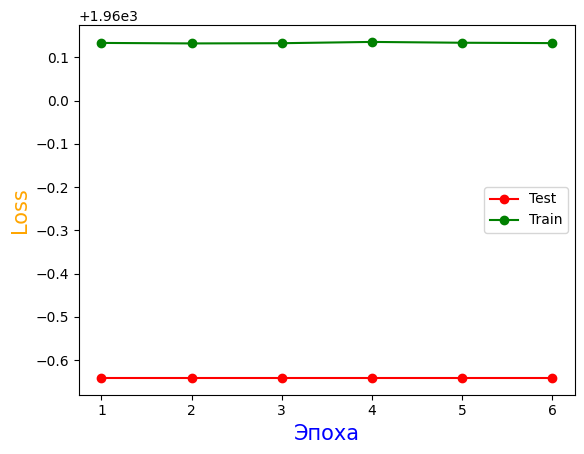

Эпоха 7 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 7 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 7, train loss: 1960.1340269698908, test loss: 1959.3589024307705


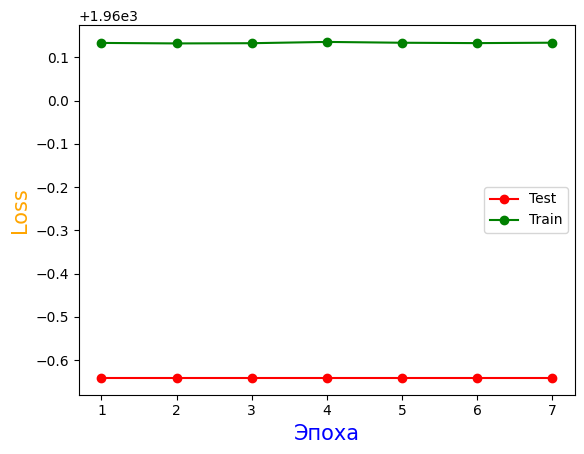

Эпоха 8 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 8 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 8, train loss: 1960.1336595123064, test loss: 1959.3589024307705


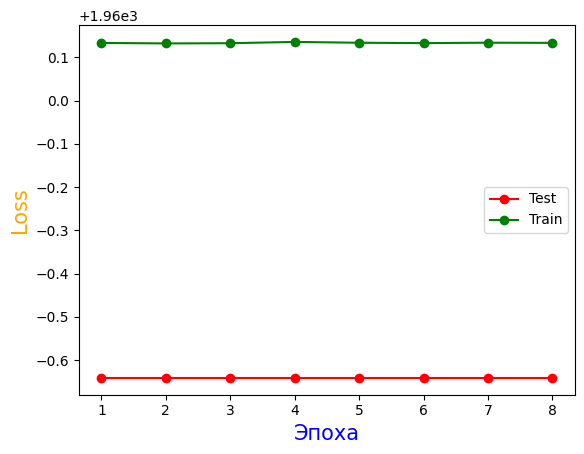

Эпоха 9 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 9 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 9, train loss: 1960.1321472959758, test loss: 1959.3589024307705


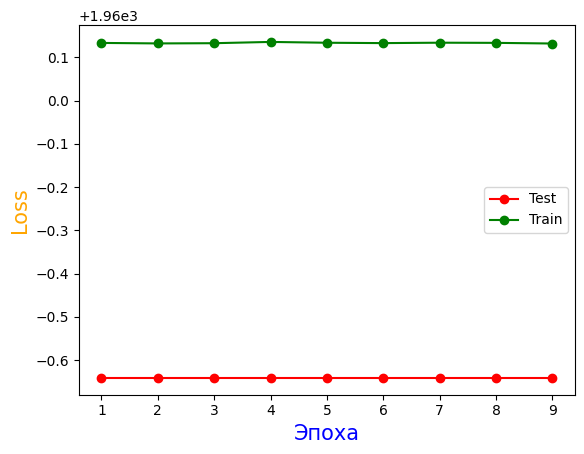

Эпоха 10 - train:   0%|          | 0/3623 [00:00<?, ?it/s]

Эпоха 10 - test:   0%|          | 0/404 [00:00<?, ?it/s]

Эпоха 10, train loss: 1960.1333019942037, test loss: 1959.3589024307705

Min Loss
Train: 1960.1321472959758	Test: 1959.3589024307705


In [17]:
arr_val_loss = []
arr_learn_loss = []
ep = []
for epoch in range(10):
    model.train()
    if len(ep) > 0:
        fig, axs = plt.subplots()
        axs.plot(ep, arr_val_loss, 'ro-', label='Test')
        axs.plot(ep, arr_learn_loss, 'go-', label='Train')
        axs.set_xlabel("Эпоха", fontsize=15, color='blue')
        axs.set_ylabel("Loss", fontsize=15, color='orange')
        axs.legend()
        plt.show()
        
    loss_learn = []
    for x_train, y_train in tqdm(train_dataloader, desc=f'Эпоха {epoch+1} - train'):         
        optimizer.zero_grad()
        y_pred = model.forward(x_train)
        y_train = y_train.unsqueeze(1)
        assert y_pred.shape == y_train.shape
        loss = rmse(y_pred, y_train)
        loss_learn.append(loss.detach().numpy().flatten().tolist())
        loss.backward()
        optimizer.step()
    arr_learn_loss.append(np.array(loss_learn).mean())

    model.eval()
    val_loss = []  
    with torch.no_grad():  
        for x_val, y_val in tqdm(val_dataloader, desc=f'Эпоха {epoch+1} - test'): 
            y_pred_val = model.forward(x_val)
            y_val = y_val.unsqueeze(1)
            assert y_pred_val.shape == y_val.shape
            loss = rmse(y_val, y_pred_val)
            val_loss.append(loss.detach().numpy().flatten().tolist())
    arr_val_loss.append(np.array(val_loss).mean())       
    
    ep.append(len(ep)+1)

    print(f'Эпоха {epoch+1}, train loss: {np.array(loss_learn).mean()}, test loss: {np.array(val_loss).mean()}')

    
print(f'\nMin Loss\nTrain: {min(arr_learn_loss)}\tTest: {min(arr_val_loss)}')

## Real network

Обучим полносвязную нейросеть, чтобы посмотреть, как она справится с даннрй задачей



Использую relu активатор, dropout: 0.1, adam оптимизатор с 0.05 lr, 0.05 wd.

In [18]:
# class Net0(nn.Module):
#     def __init__(self, input_size):
#         super(Net0, self).__init__()

#         self.norm_1 = nn.BatchNorm1d(400)
#         self.lr1 = nn.Linear(input_size, 400, bias=False)
#         self.act_1 = nn.ReLU()

#         self.lr2 = nn.Linear(400, 300, bias=False)
#         self.act_2 = nn.ReLU()

#         self.lr3 = nn.Linear(300, 240, bias=False)
#         self.act_3 = nn.ReLU()

#         self.lr4 = nn.Linear(240, 180, bias=False)
#         self.act_4= nn.ReLU()
        
#         self.lr5 = nn.Linear(180, 120, bias=False)
#         self.act_5= nn.ReLU()
        
#         self.lr6 = nn.Linear(120, 90, bias=False)
#         self.act_6= nn.ReLU()
        
#         self.lr7 = nn.Linear(90, 40, bias=False)
#         self.act_7= nn.ReLU()

#         self.dropout = nn.Dropout(0.1)
#         self.lr8 = nn.Linear(40, 1, bias=False)

#     def forward(self, x):
#         x = self.act_1(self.norm_1(self.lr1(x)))
#         x = self.dropout(x)

#         x = self.act_2(self.lr2(x))
#         x = self.dropout(x)

#         x = self.act_3(self.lr3(x))
#         x = self.dropout(x)

#         x = self.act_4(self.lr4(x))
#         x = self.dropout(x)
        
#         x = self.act_5(self.lr5(x))
#         x = self.dropout(x)
        
#         x = self.act_6(self.lr6(x))
#         x = self.dropout(x)
        
#         x = self.act_7(self.lr7(x))
#         x = self.dropout(x)
        
#         x = self.lr8(x)

#         return x
    
# model = Net0(90)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay=0.005)

__Min Loss__

Train: 220.702<br>
Test: 19.137

Лучший loss: 19.137. Loss сильно скачет на тесте, так что попробую нормировать все слои, кроме последнего.

In [19]:
class Net1(nn.Module):
    def __init__(self, input_size):
        super(Net1, self).__init__()

        self.norm_1 = nn.BatchNorm1d(400)
        self.lr1 = nn.Linear(input_size, 400, bias=False)
        self.act_1 = nn.ReLU()

        self.norm_2 = nn.BatchNorm1d(300)
        self.lr2 = nn.Linear(400, 300, bias=False)
        self.act_2 = nn.ReLU()

        self.norm_3 = nn.BatchNorm1d(240)
        self.lr3 = nn.Linear(300, 240, bias=False)
        self.act_3 = nn.ReLU()

        self.norm_4 = nn.BatchNorm1d(180)
        self.lr4 = nn.Linear(240, 180, bias=False)
        self.act_4= nn.ReLU()
        
        self.norm_5 = nn.BatchNorm1d(120)
        self.lr5 = nn.Linear(180, 120, bias=False)
        self.act_5= nn.ReLU()
        
        self.norm_6 = nn.BatchNorm1d(90)
        self.lr6 = nn.Linear(120, 90, bias=False)
        self.act_6= nn.ReLU()
        
        self.norm_7 = nn.BatchNorm1d(40)
        self.lr7 = nn.Linear(90, 40, bias=False)
        self.act_7= nn.ReLU()

        self.dropout = nn.Dropout(0.1)
        self.lr8 = nn.Linear(40, 1, bias=False)

    def forward(self, x):
        x = self.act_1(self.norm_1(self.lr1(x)))
        x = self.dropout(x)

#         x = self.act_2(self.lr2(x))
        x = self.act_2(self.norm_2(self.lr2(x)))
        x = self.dropout(x)

#         x = self.act_3(self.lr3(x))
        x = self.act_3(self.norm_3(self.lr3(x)))
        x = self.dropout(x)

#         x = self.act_4(self.lr4(x))
        x = self.act_4(self.norm_4(self.lr4(x)))
        x = self.dropout(x)
        
#         x = self.act_5(self.lr5(x))
        x = self.act_5(self.norm_5(self.lr5(x)))
        x = self.dropout(x)
        
#         x = self.act_6(self.lr6(x))
        x = self.act_6(self.norm_6(self.lr6(x)))
        x = self.dropout(x)
        
#         x = self.act_7(self.lr7(x))
        x = self.act_7(self.norm_7(self.lr7(x)))
        #x = self.dropout(x) #for v2
        
        x = self.lr8(x)

        return x
    
model = Net1(90)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay=0.005)

__Min Loss__

Train: 9.82<br>
Test: 8.735

Лучший loss: 8.735. Графики стали более плавные. Попробую заменить оптимизатор Adam на SGD.

In [20]:
# class Net2(nn.Module):
#     def __init__(self, input_size):
#         super(Net2, self).__init__()

#         self.norm_1 = nn.BatchNorm1d(400)
#         self.lr1 = nn.Linear(input_size, 400, bias=False)
#         self.act_1 = nn.ReLU()

#         self.norm_2 = nn.BatchNorm1d(300)
#         self.lr2 = nn.Linear(400, 300, bias=False)
#         self.act_2 = nn.ReLU()

#         self.norm_3 = nn.BatchNorm1d(240)
#         self.lr3 = nn.Linear(300, 240, bias=False)
#         self.act_3 = nn.ReLU()

#         self.norm_4 = nn.BatchNorm1d(180)
#         self.lr4 = nn.Linear(240, 180, bias=False)
#         self.act_4= nn.ReLU()
        
#         self.norm_5 = nn.BatchNorm1d(120)
#         self.lr5 = nn.Linear(180, 120, bias=False)
#         self.act_5= nn.ReLU()
        
#         self.norm_6 = nn.BatchNorm1d(90)
#         self.lr6 = nn.Linear(120, 90, bias=False)
#         self.act_6= nn.ReLU()
        
#         self.norm_7 = nn.BatchNorm1d(40)
#         self.lr7 = nn.Linear(90, 40, bias=False)
#         self.act_7= nn.ReLU()

#         self.dropout = nn.Dropout(0.1)
#         self.lr8 = nn.Linear(40, 1, bias=False)

#     def forward(self, x):
#         x = self.act_1(self.norm_1(self.lr1(x)))
#         x = self.dropout(x)

# #         x = self.act_2(self.lr2(x))
#         x = self.act_2(self.norm_2(self.lr2(x)))
#         x = self.dropout(x)

# #         x = self.act_3(self.lr3(x))
#         x = self.act_3(self.norm_3(self.lr3(x)))
#         x = self.dropout(x)

# #         x = self.act_4(self.lr4(x))
#         x = self.act_4(self.norm_4(self.lr4(x)))
#         x = self.dropout(x)
        
# #         x = self.act_5(self.lr5(x))
#         x = self.act_5(self.norm_5(self.lr5(x)))
#         x = self.dropout(x)
        
# #         x = self.act_6(self.lr6(x))
#         x = self.act_6(self.norm_6(self.lr6(x)))
#         x = self.dropout(x)
        
# #         x = self.act_7(self.lr7(x))
#         x = self.act_7(self.norm_7(self.lr7(x)))
        
#         x = self.lr8(x)

#         return x
    
    
# model = Net2(90)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.005, weight_decay=0.005)

__Min Loss__

Train: 10.11<br>
Test: 9.078

Лучший loss: 9.078, стало похуже. Углублю нейросеть на один слой и верну оптимизатор Adam.

In [21]:
# class Net3(nn.Module):
#     def __init__(self, input_size):
#         super(Net3, self).__init__()

#         self.norm_1 = nn.BatchNorm1d(400)
#         self.lr1 = nn.Linear(input_size, 400, bias=False)
#         self.act_1 = nn.ReLU()

#         self.norm_2 = nn.BatchNorm1d(300)
#         self.lr2 = nn.Linear(400, 300, bias=False)
#         self.act_2 = nn.ReLU()

#         self.norm_3 = nn.BatchNorm1d(240)
#         self.lr3 = nn.Linear(300, 240, bias=False)
#         self.act_3 = nn.ReLU()

#         self.norm_4 = nn.BatchNorm1d(180)
#         self.lr4 = nn.Linear(240, 180, bias=False)
#         self.act_4= nn.ReLU()
        
#         self.norm_5 = nn.BatchNorm1d(120)
#         self.lr5 = nn.Linear(180, 120, bias=False)
#         self.act_5= nn.ReLU()
        
#         self.norm_6 = nn.BatchNorm1d(90)
#         self.lr6 = nn.Linear(120, 90, bias=False)
#         self.act_6= nn.ReLU()
        
#         self.norm_7 = nn.BatchNorm1d(40)
#         self.lr7 = nn.Linear(90, 40, bias=False)
#         self.act_7= nn.ReLU()
        
#         self.norm_8 = nn.BatchNorm1d(20)
#         self.lr8 = nn.Linear(40, 20, bias=False)
#         self.act_8= nn.ReLU()

#         self.dropout = nn.Dropout(0.1)
#         self.lr9 = nn.Linear(20, 1, bias=False)

#     def forward(self, x):
#         x = self.act_1(self.norm_1(self.lr1(x)))
#         x = self.dropout(x)

# #         x = self.act_2(self.lr2(x))
#         x = self.act_2(self.norm_2(self.lr2(x)))
#         x = self.dropout(x)

# #         x = self.act_3(self.lr3(x))
#         x = self.act_3(self.norm_3(self.lr3(x)))
#         x = self.dropout(x)

# #         x = self.act_4(self.lr4(x))
#         x = self.act_4(self.norm_4(self.lr4(x)))
#         x = self.dropout(x)
        
# #         x = self.act_5(self.lr5(x))
#         x = self.act_5(self.norm_5(self.lr5(x)))
#         x = self.dropout(x)
        
# #         x = self.act_6(self.lr6(x))
#         x = self.act_6(self.norm_6(self.lr6(x)))
#         x = self.dropout(x)
        
# #         x = self.act_7(self.lr7(x))
#         x = self.act_7(self.norm_7(self.lr7(x)))
#         x = self.dropout(x)
        
#         x = self.act_8(self.norm_8(self.lr8(x)))
        
#         x = self.lr9(x)

#         return x
    
# model = Net3(90)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.005)

__Min Loss__

Train: 23.007<br>
Test: 11.075

Лучший loss: 11.075. Заменю активатор на Silu.

In [22]:
# class Net4(nn.Module):
#     def __init__(self, input_size):
#         super(Net4, self).__init__()

#         self.norm_1 = nn.BatchNorm1d(400)
#         self.lr1 = nn.Linear(input_size, 400, bias=False)
#         self.act_1 = nn.SiLU()

#         self.norm_2 = nn.BatchNorm1d(300)
#         self.lr2 = nn.Linear(400, 300, bias=False)
#         self.act_2 = nn.SiLU()

#         self.norm_3 = nn.BatchNorm1d(240)
#         self.lr3 = nn.Linear(300, 240, bias=False)
#         self.act_3 = nn.SiLU()

#         self.norm_4 = nn.BatchNorm1d(180)
#         self.lr4 = nn.Linear(240, 180, bias=False)
#         self.act_4= nn.SiLU()
        
#         self.norm_5 = nn.BatchNorm1d(120)
#         self.lr5 = nn.Linear(180, 120, bias=False)
#         self.act_5= nn.SiLU()
        
#         self.norm_6 = nn.BatchNorm1d(90)
#         self.lr6 = nn.Linear(120, 90, bias=False)
#         self.act_6= nn.SiLU()
        
#         self.norm_7 = nn.BatchNorm1d(40)
#         self.lr7 = nn.Linear(90, 40, bias=False)
#         self.act_7= nn.SiLU()
        
#         self.norm_8 = nn.BatchNorm1d(20)
#         self.lr8 = nn.Linear(40, 20, bias=False)
#         self.act_8= nn.SiLU()

#         self.dropout = nn.Dropout(0.1)
#         self.lr9 = nn.Linear(20, 1, bias=False)

#     def forward(self, x):
#         x = self.act_1(self.norm_1(self.lr1(x)))
#         x = self.dropout(x)

# #         x = self.act_2(self.lr2(x))
#         x = self.act_2(self.norm_2(self.lr2(x)))
#         x = self.dropout(x)

# #         x = self.act_3(self.lr3(x))
#         x = self.act_3(self.norm_3(self.lr3(x)))
#         x = self.dropout(x)

# #         x = self.act_4(self.lr4(x))
#         x = self.act_4(self.norm_4(self.lr4(x)))
#         x = self.dropout(x)
        
# #         x = self.act_5(self.lr5(x))
#         x = self.act_5(self.norm_5(self.lr5(x)))
#         x = self.dropout(x)
        
# #         x = self.act_6(self.lr6(x))
#         x = self.act_6(self.norm_6(self.lr6(x)))
#         x = self.dropout(x)
        
# #         x = self.act_7(self.lr7(x))
#         x = self.act_7(self.norm_7(self.lr7(x)))
#         x = self.dropout(x)
        
#         x = self.act_8(self.norm_8(self.lr8(x)))
        
#         x = self.lr9(x)

#         return x
    
# model = Net4(90)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.005)

__Min Loss__

Train: 18.355<br>
Test: 11.314

Лучший лосс: 11.314

Эпоха: 6
Loss Train: 9.829
Loss Test: 8.735


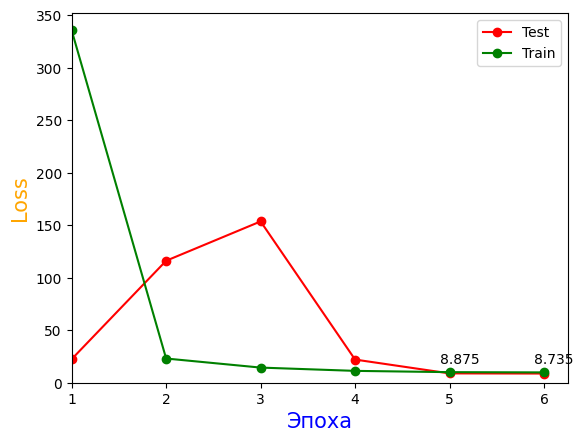


Min Loss
Train: 9.829	Test: 8.735


In [23]:
arr_val_loss = []
arr_learn_loss = []
ep = []
#mseloss = nn.MSELoss()
flag = False
max_epoch = 10
for epoch in range(max_epoch+1):           
        if len(ep) > 0:
            fig, axs = plt.subplots()
            axs.plot(ep, arr_val_loss, 'ro-', label='Test')
            axs.plot(ep, arr_learn_loss, 'go-', label='Train')
            axs.set_xlabel("Эпоха", fontsize=15, color='blue')
            axs.set_ylabel("Loss", fontsize=15, color='orange')
            for i, v in enumerate(arr_val_loss):
                if v < 9:
                    axs.annotate(str(v), xy=(i+1,v), xytext=(-7,7), textcoords='offset points')
            axs.set_ylim(bottom=0)
            axs.set_xlim(left=1)
            axs.legend()
            plt.show()

        if flag == True or epoch==max_epoch:
            break
        loss_learn = []
        model.train()

        for x_train, y_train in tqdm(train_dataloader, desc=f'Эпоха {epoch+1} - train'):
            optimizer.zero_grad()
            y_pred = model(x_train)
            y_train = y_train.unsqueeze(1)
            assert y_pred.shape == y_train.shape
            loss = rmse(y_pred, y_train)
            loss_learn.append(loss.detach().numpy().flatten().tolist())
            loss.backward()
            optimizer.step() 

        val_loss = []
        model.eval()
        with torch.no_grad(): 
            for x_val, y_val in tqdm(val_dataloader, desc=f'Эпоха {epoch+1} - test'): 
                y_pred_val = model(x_val)
                y_val = y_val.unsqueeze(1)
                assert y_pred_val.shape == y_val.shape
                loss = rmse(y_pred_val, y_val)
                val_loss.append(loss.detach().numpy().flatten().tolist())
            
        arr_val_loss.append(round(np.array(val_loss).mean(), 3))
        arr_learn_loss.append(round(np.array(loss_learn).mean(), 3))
        
        ep.append(len(ep)+1)
        
        clear_output()
        if len(arr_val_loss) > 0 and arr_val_loss[-1] < 8.75:
            flag = True
        if len(ep) > 0:
            print(f'Эпоха: {epoch+1}\nLoss Train: {arr_learn_loss[ep[-1] - 1]}\nLoss Test: {arr_val_loss[ep[-1] - 1]}')
            
print(f'\nMin Loss\nTrain: {min(arr_learn_loss)}\tTest: {min(arr_val_loss)}')